In [1]:
# importing the required libraries
library(seewave)
library(stringr)
library(keras)
library(tuneR)
library(splitstackshape)


Attaching package: ‘tuneR’

The following object is masked from ‘package:keras’:

    normalize



In [2]:
# reading input file
wav_file = readWave("data/data_speech_commands_v0.01/no/012c8314_nohash_0.wav")
wav_file


Wave Object
	Number of Samples:      16000
	Duration (seconds):     1
	Samplingrate (Hertz):   16000
	Channels (Mono/Stereo): Mono
	PCM (integer format):   TRUE
	Bit (8/16/24/32/64):    16 


In [3]:
# accessing the attributesof the wave object

# sample
head(wav_file@left)
# sampling rate
paste("Sampling rate of the audio:", wav_file@samp.rate)
# num of samples
paste("Number of samples in the audio:",length(wav_file@left))
# duration of audio
paste("Duration of audio is:",length(wav_file@left)/wav_file@samp.rate,"second")

[1] 236 200 181 191 198 198

[1] "Sampling rate of the audio: 16000"

[1] "Number of samples in the audio: 16000"

[1] "Duration of audio is: 1 second"

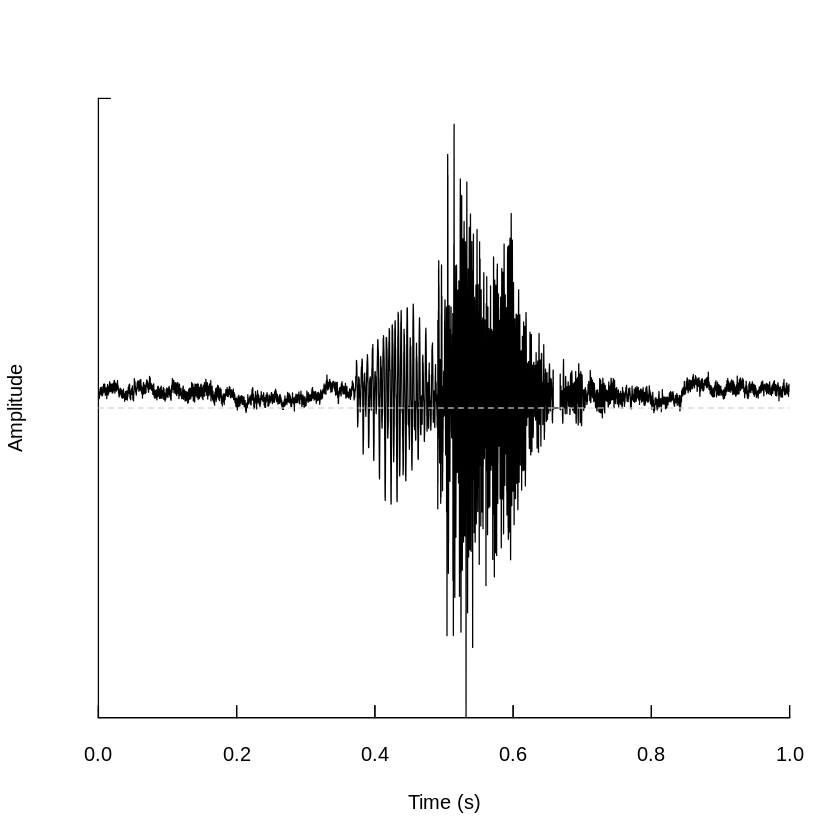

In [4]:
# plotting the oscillogram of the sound wave 

# wave data
wave_data = wav_file@left
# Number of data samples
num_samples = length(wav_file@left)
# sampling rate of the wave
sampling_rate = wav_file@samp.rate

# plot oscillogram
oscillo(wave = wav_file,f = sampling_rate)

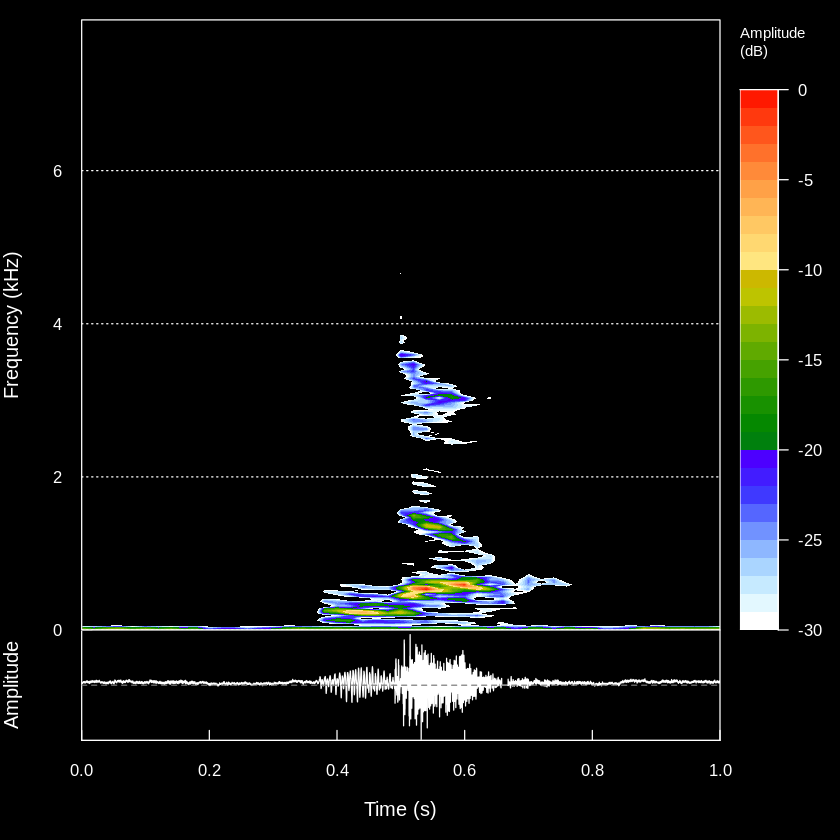

In [5]:
# plotting the spectrogram
window_length = 512
overlap = 40
window_type = "hanning"

# plot spectrogram
spectro(wav_file, f=sampling_rate, wl=512, ovlp=40, osc=TRUE,colgrid="white", colwave="white", colaxis="white", collab="white", colbg="black")

In [6]:
# looking at the structure of the values returned by the spectro() function
stft_wave = spectro(wave_data,f = sampling_rate,wl = window_length,ovlp = overlap,wn = window_type,complex = T,plot = F,dB = NULL,norm = F)
str(stft_wave)

List of 3
 $ time: num [1:51] 0 0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 ...
 $ freq: num [1:256] 0 0.0312 0.0625 0.0938 0.125 ...
 $ amp : cplx [1:256, 1:51] 148.8+0i -74.65+6.57i -0.74-4.15i ...


In [7]:
#  dimension of amplitude contour
dim(stft_wave$amp)

[1] 256  51

In [9]:
# fft size
fft_size = window_length/2
fft_size

[1] 256

In [8]:
# number of fft windows
num_fft_windows = length(seq(1, num_samples + 1 - window_length, window_length - (overlap * window_length/100)))
num_fft_windows

[1] 51

In [10]:
# listing all the files inside dataspeech_commands_v0.01_ folder
files = list.files("data/data_speech_commands_v0.01",all.files = T,full.names = F,recursive = T)

paste("Number audio files in datase: ",length(files))

file_df = as.data.frame(files)
head(file_df)

[1] "Number audio files in datase:  64728"

In [12]:
# creating a data frame which contains file names and respective class label

file_df$class = str_split_fixed(file_df$files,pattern = "/",n = 2)[,1]
file_df <- file_df[sample(nrow(file_df)),]
rownames(file_df) <- NULL
file_df = file_df[file_df$class %in% c("bird","no","off"),]
file_df$files <- as.character(file_df$files)
file_df$class <- as.numeric(as.factor(file_df$class)) -1
rownames(file_df) <- NULL
head(file_df)

files,class
bird/75915c90_nohash_0.wav,0
no/8281a2a8_nohash_2.wav,1
no/1625acd8_nohash_0.wav,1
bird/ae71797c_nohash_2.wav,0
off/33246bc2_nohash_0.wav,2
bird/3565ca83_nohash_1.wav,0


In [13]:
# creating a variable to set the number of unique labels
num_speech_labels = length(unique(file_df$class))
num_speech_labels

[1] 3

In [14]:
# split data into train, test and validation
set.seed(200)
train_index = stratified(file_df,group = "class",.80,keep.rownames = T)$rn
test_index = setdiff(row.names(file_df),train_index)
val_index = stratified(file_df[train_index,],group = "class",.20,keep.rownames = T)$rn

train_data = file_df[setdiff(train_index,val_index),]
test_data = file_df[test_index,]
val_data = file_df[val_index,]

In [15]:
# shuffle train and test data
test_data = test_data[sample(nrow(test_data)),]
train_data = train_data[sample(nrow(train_data)),]

In [16]:
# building model to classify audio samples
model <- keras_model_sequential()
model %>%  
  layer_conv_2d(input_shape = c(fft_size, num_fft_windows,1), 
                filters = 32, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_dropout(rate = 0.25) %>% 
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'tanh') %>% 
  layer_dense(units = num_speech_labels, activation = 'softmax')

In [17]:
# compiling the model
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "rmsprop",
  metrics = c('accuracy')
)

In [18]:
# visualising the summary of the model
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 254, 49, 32)             320         
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 127, 24, 32)             0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 125, 22, 64)             18496       
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 62, 11, 64)              0           
________________________________________________________________________________
dropout (Dropout)                   (None, 62, 11, 64)              0           
________________________________________________________________________________
flatten 

In [19]:
# building data generator
data_generator <-  function(data,windowlen,overlap,numfftwindows,fftsize,windowtype,num_classes,batchsize) {
    
    function(){
        indexes <- sample(1:nrow(data), batchsize, replace = TRUE)
        x <- array(0, dim = c(length(indexes),fftsize, numfftwindows,1))
        y <- array(0, dim = c(length(indexes)))
        
        for (j in 1:length(indexes)){
            wav_file_name = data[indexes[j],"files"]  %>% as.character()
            wav_file = readWave(paste0("data/data_speech_commands_v0.01/",wav_file_name))
            # wave attributes
            wave_data = wav_file@left
            num_samples = length(wav_file@left)
            sampling_rate = wav_file@samp.rate
            # accomodating varying input lengths            
            if(num_samples < 16000){
                zero_pad = rep(0,16000 - length(wave_data))
                wave_data = c(wave_data,zero_pad)
            }else if(num_samples > 16000){
                wave_data = wave_data[1:16000]
            }
            # spectrogram representaion
            spectrogram_data = spectro(wave_data,f = sampling_rate ,wl = windowlen,ovlp = overlap,wn = windowtype,complex = T,plot = F,dB = NULL,norm = F)
            spectrogram_data = spectrogram_data$amp
            spectrogram_data = Mod(spectrogram_data)
            
            # imputing NaN and Inf
            if((sum(is.nan(spectrogram_data))> 0)){
                spectrogram_data[which(is.nan(spectrogram_data))] =  log(0.01)
            }else if((sum(is.infinite(spectrogram_data)) >0)){
                spectrogram_data[which(is.infinite(spectrogram_data))] =  log(0.01)
            }else if((sum(is.infinite(spectrogram_data)) >0)){
                spectrogram_data[which(is.na(spectrogram_data))] =  log(0.01)
            }
                
            spectrogram_data = array_reshape(spectrogram_data,dim = c(fftsize,numfftwindows,1))
            
            x[j,,,] =  spectrogram_data
            y[j] = data[indexes[j],c("class")] %>% as.matrix()
          }
          list(x, to_categorical(y,num_classes = num_classes))
    }
  }


In [20]:
# creating train and validation generators
batch_size = 20
epochs = 2

# train and validation generator
train_generator = data_generator(data = train_data,windowlen = window_length,overlap = overlap,numfftwindows = num_fft_windows,fftsize = fft_size, windowtype = window_type,num_classes = num_speech_labels,batchsize = batch_size)
val_generator = data_generator(data = val_data,windowlen = window_length,overlap = overlap,numfftwindows = num_fft_windows,fftsize = fft_size, windowtype = window_type,num_classes = num_speech_labels,batchsize = batch_size)

In [75]:
# defining model callbacks
model_name = "speech_rec_"

checkpoint_dir <- "checkpoints_speech_recognition"
dir.create(checkpoint_dir)
filepath <- file.path(checkpoint_dir, paste0(model_name,"weights.{epoch:02d}-{val_loss:.2f}.hdf5",sep=""))

cp_callback <- list(callback_model_checkpoint(mode = "auto",
    filepath = filepath,
    save_best_only = TRUE,
    verbose = 1),
    callback_early_stopping(min_delta = 0.05,patience = 10))

In [80]:
# training the model
model %>% fit_generator(generator = train_generator,
                        epochs = epochs,
                        steps_per_epoch = nrow(train_data)/batch_size,
                        validation_data = val_generator ,
                        validation_steps = nrow(val_data)/batch_size,
                        callbacks = cp_callback
                       )

In [86]:
# predicting class for a sample from test data
test = readWave("data/data_speech_commands_v0.01/no//0132a06d_nohash_2.wav")
# matrix corresponding to the amplitude values
test = spectro(test,wl = window_length,ovlp = overlap,wn = "hanning",complex = T,plot = F,dB = NULL,norm = F)
test = test$amp
test = array_reshape(test,dim = c(fft_size,num_fft_windows,1))
# predict label of test sample.
model %>% predict_classes( array_reshape(test,dim = c(1,fft_size,num_fft_windows,1)))

[1] 1